In [37]:
import numpy as np
import math
import collections
from math import ceil,log
import random
from collections import deque
from skimage import measure
from scipy import spatial

In [38]:
InputMatrixRow = 100
InputMatrixCol = 100
Positions = [[0, 10],[80,20],[0,40],[0,90],[60,60]]
speed = np.array([1,0.5,1,5,1])
coverage = np.array([5,2.5,2.5,1,1])
NumberOfRobots = len(Positions)

In [39]:
PositionOfObstacles = []
for x in range(30,50):
    for y in range(30,50):
        PositionOfObstacles.append([x, y])
for x in range(10,50):
    PositionOfObstacles.append([10, x])
for x in range(0,70):
       PositionOfObstacles.append([x, 70])
for x in range(30,50):
       for y in range(30,50):
            PositionOfObstacles.append([x, y])

In [40]:
#PositionOfObstacles = [[90, 90], [2, 2]]
obstacle = 0
if(len(PositionOfObstacles)>0):
    obstacle = 1

In [41]:
Matrix = np.ones([InputMatrixRow,InputMatrixCol], dtype = bool)

In [42]:
for y in PositionOfObstacles:
        Matrix[y[0],y[1]] = False

In [43]:
def neighboursA(x, y):
    for dx in [-1, 1]:
        yield x + dx, y
    for dy in [-1, 1]:
        yield x, y + dy

In [44]:
def floodfillA(is_path, x, y):
    height = len(is_path)
    width = len(is_path[0])

    grid = [[None] * width for _ in is_path]
    if not is_path[x][y]:
        # If we started in a wall, we can't reach anything
        return grid
    grid[x][y] = 0
    modified = deque([(x, y)])
    while modified:
        x, y = modified.popleft()
        number = grid[x][y]
        for dx, dy in neighboursA(x, y):
            if 0 <= dx < width and 0 <= dy < height and is_path[dx][dy] and grid[dx][dy] is None:
                grid[dx][dy] = number + 1
                modified.append((dx, dy))
    return grid

In [45]:
ans = floodfillA(Matrix, 0, 0)

In [46]:
def EvaluationMatrix():
    E = np.zeros([NumberOfRobots, InputMatrixRow, InputMatrixCol]).astype('float32') 
    for x in  range(NumberOfRobots):
        E[x] = floodfillA(Matrix,Positions[x][0], Positions[x][1])
    return(E)

In [47]:
E = EvaluationMatrix()

In [48]:
A = np.zeros([InputMatrixRow,InputMatrixCol]).astype('float32') 

In [49]:
def ArgMin():
    B = np.argmin(E,axis = 0).astype('float32') 
    np.copyto(A,B)
    for x in PositionOfObstacles:
        A[x[0]][x[1]] = -1

In [50]:
ArgMin()

In [51]:
print(A.dtype)

float32


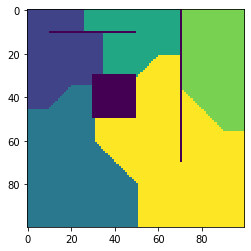

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline 
a = plt.imshow(A, interpolation='nearest')

In [53]:
LI = np.zeros([NumberOfRobots], dtype=int)

In [54]:
def L():
    unique, counts = np.unique(A, return_counts=True)
    if(obstacle):
        counts = counts[1:]
    np.copyto(LI,counts)
    print(LI)

In [55]:
L()

[1250 2425 1000 1434 3381]


In [56]:
UnoccupiedCells =  (InputMatrixCol*InputMatrixRow) -len(PositionOfObstacles)

In [57]:
FairShares = np.zeros([NumberOfRobots]).astype('float32') 
CombinedFactor = np.ones(NumberOfRobots).astype('float32') 

In [58]:
def FairShareArray():
    CombinedFactor = np.multiply(speed, coverage)
    TotalWeight = np.sum(CombinedFactor)
    np.copyto(FairShares,CombinedFactor/TotalWeight)

In [59]:
FairShareArray()

In [60]:
def FairShare(index):
    ans = LI[index] - ((UnoccupiedCells)*FairShares[index])
    return(int(ans))

In [61]:
Digits = log((InputMatrixRow*InputMatrixCol),10)
c_main = pow(10,-ceil(Digits))

In [62]:
def MiCalculation(mi,index):
    Digits = log((InputMatrixRow*InputMatrixCol),10)
    c = pow(10,-(ceil(Digits)))
    mi = mi + c*(FairShare(index))
    return mi

In [63]:
m = np.ones([NumberOfRobots]).astype('float32') 
E_Temp = np.zeros([NumberOfRobots, InputMatrixRow, InputMatrixCol]).astype('float32') 

In [64]:
Digits = log((InputMatrixRow+InputMatrixCol),10)
c_con = pow(10,-ceil(Digits))
print(c_con)

0.001


In [65]:
def ContinuityCheckA():
    img,num  = measure.label(A, background=-1,return_num = True, connectivity = 1)
    if num == NumberOfRobots:
        return
    else:
        global obstacle,E
        obstacle_pt = 0 
        if(obstacle == 1):
            obstacle_pt = 1
        R = {}
        Q = {}
        ContinuityChecker = np.zeros(num).astype('float32') 
        indicesAZ = np.indices(A.shape).T[:,:,[1, 0]]
        x_index = 0 
        for x in range(1,num+1):
            ContinuityChecker[x_index] = A[indicesAZ[img==x][0][0]][indicesAZ[img==x][0][1]]
            x_index = x_index + 1
        a = np.array(np.unique(ContinuityChecker, return_counts=True)).astype('float32') 
        for x in range(NumberOfRobots): #1, num to skip -1 of obstacle and 3 is number of robots change later
            if (a[1][x] > 1):
                label_traverse = int(a[0][x])
                q = []
                flag = 0 
                for y in range(num):
                    temp = []
                    if ContinuityChecker[y] == label_traverse:
                        start_pt = np.array([Positions[label_traverse][0],Positions[label_traverse][1]])
                        if(any(np.equal(indicesAZ[img==y+1],start_pt).all(1))):
                            R[label_traverse] = [indicesAZ[img==(y+1)]]
                        else:
                            temp = indicesAZ[img==(y+1)]
                            q.append(temp)
                Q[label_traverse] = q
                ro = R[label_traverse]
                qo = Q[label_traverse]
                ro_new = np.array(ro[0]).astype('float32') 
                qo_new = np.array(qo[0]).astype('float32') 
                for ter in range(1,len(qo)):
                    temp  = np.array(qo[ter]).astype('float32') 
                ro_tree = spatial.KDTree(ro_new)
                qo_tree = spatial.KDTree(qo_new)
                c = np.ones([InputMatrixRow,InputMatrixCol]).astype('float32') 
                for i in range(InputMatrixRow):
                    for j in range(InputMatrixCol):
                        distance_r, index_r = ro_tree.query([i,j])
                        distance_q, index_q = qo_tree.query([i,j])
                        c[i,j] = (abs(ro_new[index_r][0]-i)+ abs(ro_new[index_r][1]-j)) - (abs(qo_new[index_q][0]-i) + abs(qo_new[index_q][1]-j))
                c = 1 + c*c_con
                E[label_traverse] = np.multiply(c,E[label_traverse]) # do the freeze
                #E[label_traverse]= MulAns   

In [66]:
SumOfErrors = np.sum((np.absolute((np.ceil(FairShares*UnoccupiedCells)) - LI)), dtype=int)
print(SumOfErrors)

8439


In [67]:
History = np.zeros([2,200]).astype('float32') 

In [68]:
def HistoryLog(x):
    global LeastRegions,LeastError,UnoccupiedCells
    CurrentRegion = measure.label(A, background=-1,return_num = True, connectivity = 1)[1]
    CurrentError  = np.sum((np.absolute((np.ceil(FairShares*UnoccupiedCells)) - LI)), dtype=int)
    print(CurrentError)
    History[0][x] = CurrentRegion
    History[1][x] = CurrentError
    if(CurrentRegion==LeastRegions and CurrentError<LeastError):
        LeastError = CurrentError
        LeastRegions = CurrentRegion
        np.copyto(BestMatrix,A)
    elif(CurrentRegion<LeastRegions and not(LeastError<CurrentError)):
        LeastError = CurrentError
        LeastRegions = CurrentRegion
        np.copyto(BestMatrix,A)
    elif(CurrentRegion>LeastRegions and LeastError>CurrentError):
        CurrentClass = ceil((CurrentError/(UnoccupiedCells*2))*20)
        LeastClass = ceil((LeastError/(UnoccupiedCells*2))*20)
        print(CurrentClass,LeastClass)
        if(CurrentClass<LeastClass):
            LeastError = CurrentError
            LeastRegions = CurrentRegion
            np.copyto(BestMatrix,A)
    

In [69]:
BestMatrix = np.ones([InputMatrixRow,InputMatrixCol]).astype('float32') 
np.copyto(BestMatrix,A)
LeastError = SumOfErrors
LeastRegions = measure.label(A, background=-1,return_num = True, connectivity = 1)[1]

In [70]:
def MiStep():
    L()
    for x in range(NumberOfRobots):
        m[x] = MiCalculation(1,x)
        E[x] = E[x]*m[x]
    ArgMin()

In [71]:
for x in range(1,200):
    MiStep()
   # HistoryLog(x)
   # if(x%10==0):
    ContinuityCheckA()


[1250 2425 1000 1434 3381]
[1562 2233 1047 1948 2700]
[1838 2075 1088 2486 2003]
[2102 1897 1109 2708 1674]
[2455 1687 1098 2845 1405]
[3118 1254 1094 2898 1126]
[3385 1015 1178 2932  980]
[3514  921 1215 2944  896]
[3364  971 1282 3002  871]
[3281  986 1350 3038  835]
[3175  983 1478 3062  792]
[3224  943 1467 3093  763]
[3231  917 1486 3122  734]
[3161  918 1563 3132  716]
[3127  911 1604 3145  703]
[3137  885 1636 3145  687]
[3107  876 1675 3156  676]
[3097  870 1702 3148  673]
[3106  847 1724 3145  668]
[3128  840 1707 3143  672]
[3147  835 1691 3143  674]
[3155  835 1679 3143  678]
[3156  837 1675 3143  679]
[3156  840 1667 3143  684]
[3159  840 1663 3143  685]
[3161  840 1661 3143  685]
[3162  841 1656 3144  687]
[3161  843 1651 3147  688]
[3157  844 1646 3152  691]
[3158  844 1643 3154  691]
[3158  844 1641 3156  691]
[3159  846 1637 3156  692]
[3160  846 1635 3156  693]
[3159  847 1634 3156  694]
[3160  847 1632 3156  695]
[3161  847 1631 3156  695]
[3160  848 1631 3156  695]
[

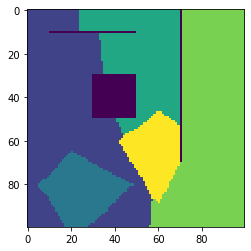

In [36]:
plt.imshow(A, interpolation='nearest')

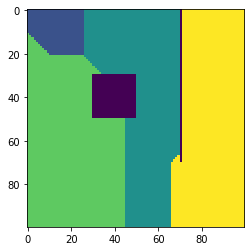

In [38]:
plt.imshow(BestMatrix, interpolation='nearest')

In [36]:
print(LI)

[3420  930 1760 3420]


In [57]:
print(History)
print(LI)

[[0.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00
  4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.000e+00 4.